In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
dataframe = pd.read_csv("SP500DATA.csv")
print(dataframe)# Text file data converted to integer data type
Shillerdataframe = pd.read_csv("S&P500 Schiller PE ratio.csv")
print(Shillerdataframe)

           Date    Price     Open     High      Low Vol.  Change %
0    01/12/2021  4766.18  4623.80  4808.52  4494.20    -    0.0436
1    01/11/2021  4567.00  4616.47  4743.74  4560.26    -   -0.0083
2    01/10/2021  4605.38  4324.71  4608.70  4278.70    -    0.0691
3    01/09/2021  4307.54  4531.04  4544.58  4304.90    -   -0.0476
4    01/08/2021  4522.68  4415.90  4537.80  4369.20    -    0.0290
..          ...      ...      ...      ...      ...  ...       ...
618  01/06/1970    72.72    76.55    79.96    72.25    -   -0.0500
619  01/05/1970    76.55    81.52    82.32    68.61    -   -0.0610
620  01/04/1970    81.52    89.63    90.70    79.31    -   -0.0905
621  01/03/1970    89.63    89.50    91.07    86.19    -    0.0015
622  01/02/1970    89.50    85.02    90.33    84.64    -    0.0527

[623 rows x 7 columns]
                 DateTime  SP500PERatio
0     1871-01-01 00:00:58         11.10
1     1871-02-01 00:00:58         11.25
2     1871-03-01 00:00:58         11.52
3     1871-0

# Step 1

In [2]:
trainData = dataframe[["Price", "Open"]].to_numpy(dtype = 'float')
targetData = dataframe[["Price"]].to_numpy(dtype = 'float')
date = dataframe[["Date"]].to_numpy(dtype = "str")

norm = MinMaxScaler(feature_range = (0, 1))
trainData = norm.fit_transform(trainData)
targetData = norm.fit_transform(targetData)
trainData = np.flip(trainData)
targetData = np.flip(targetData)
date = np.flip(date)

dateAxis = []
for i in range(date.shape[0]):
    dateAxis.append(float(np.squeeze(date)[i][6:10]) + float(np.squeeze(date)[i][3:5])/12.0)
dateAxis = np.array(dateAxis)
dateAxis_test=date[438:623,:]
dateAxis = dateAxis[6:620]
print(dateAxis.shape)

(614,)


In [3]:
X = []
Y = []
for i in range(trainData.shape[0] - 5 - 4):
    X.append(trainData[i:i+6])
    Y.append(targetData[i+6:i+6+4])
X = np.array(X)
Y = np.array(Y)
Y = np.swapaxes(Y, 1, 2)
Y.shape

(614, 1, 4)

In [4]:
X_fullTraining = []
X_training = []
X_validation = []
X_test = []
Y_fullTraining = []
Y_training = []
Y_validation = []
Y_test = []

X_fullTraining, X_test, Y_fullTraining, Y_test, date_ft, date_t = train_test_split(X, Y, dateAxis, test_size=0.3, shuffle=False)
X_training, X_validation, Y_training, Y_validation, date_tr, date_v = train_test_split(X_fullTraining, Y_fullTraining, date_ft, test_size=0.3, shuffle=False)

date_test=date[438:623,:]

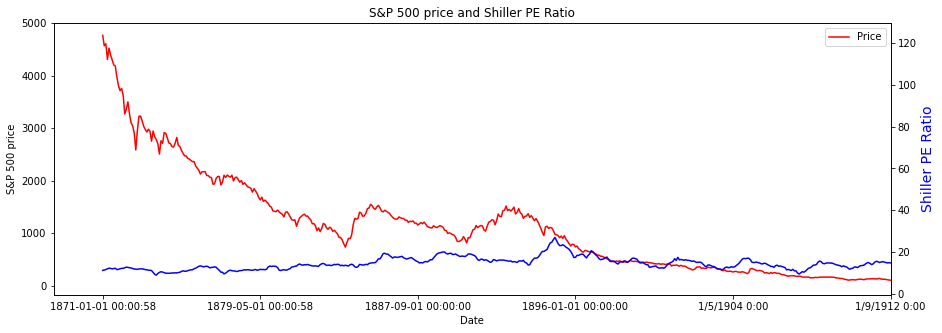

In [5]:
plt.figure(figsize=(15, 5));
#plt.plot(dataframe.Date, dataframe.Open.values, color='grey', label='Open')
# plt.plot(dataframe.Date, dataframe.Close.values, color='black', label='Close')
#plt.plot(dataframe.Date, dataframe.Low.values, color='red', label='Low')
#plt.plot(dataframe.Date, dataframe.High.values, color='green', label='High')
plt.plot(dataframe.Date, dataframe.Price.values, color = 'red', label='Price')
plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
ax2.set_xticks(ax2.get_xticks()[::100])
plt.xlim(-31.1,500.1)
# make a plot with different y-axis using second axis object
ax2.plot(Shillerdataframe.DateTime, Shillerdataframe.SP500PERatio.values,color="blue")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.show()

# Step 2

In [6]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   

        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x, hidden)
    
        out = self.fc(out)
    
        return out[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [7]:
RNN = Model(input_size=2, output_size=4, hidden_dim=16, n_layers=1)
optimizer = torch.optim.Adam(RNN.parameters(), lr=0.01)
criterion = nn.MSELoss()
RNN

Model(
  (rnn): RNN(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

# Step 3

In [8]:
xTensor = torch.from_numpy(X_fullTraining).float()
yTensor = torch.Tensor(Y_fullTraining).float()

for epoch in range(100):
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss:", loss.item())

Epoch: 0/100............. Loss: 0.032546624541282654
Epoch: 10/100............. Loss: 0.006093515548855066
Epoch: 20/100............. Loss: 0.0020460111554712057
Epoch: 30/100............. Loss: 0.0004723416641354561
Epoch: 40/100............. Loss: 0.00024030917847994715
Epoch: 50/100............. Loss: 0.00015997317677829415
Epoch: 60/100............. Loss: 9.85631559160538e-05
Epoch: 70/100............. Loss: 9.719388617668301e-05
Epoch: 80/100............. Loss: 9.249441791325808e-05
Epoch: 90/100............. Loss: 8.959144906839356e-05


In [9]:
def prediction_error(pred, actual):
    return abs(pred - actual)/pred

def plotNoiselessGraphs(output_1,output_2,output_3,output_4,Y_main,Y_plot,XAxis_date,date_pred,
    set1_title_1,set2_title_1,set3_title_1,set4_title_1,error_title):
    
    table = []

    error = prediction_error(output_1, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp1 = np.array(temp1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set1_title_1)
    ax1.plot(date_pred, output_1, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    error = prediction_error(output_2, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp2 = np.array(temp2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set2_title_1)
    ax1.plot(date_pred, output_2, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    error = prediction_error(output_3, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp3 = np.array(temp3)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set3_title_1)
    ax1.plot(date_pred, output_3, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    error = prediction_error(output_4, Y_main)
    error_dt = pd.DataFrame(data = error)
    temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
    temp4 = np.array(temp4)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(set4_title_1)
    ax1.plot(date_pred, output_plt4, color = 'blue', label = 'Pred')
    ax1.plot(XAxis_date, Y_plot, color = 'green', label = 'Actual')
    ax1.legend(loc="upper left")
    ax2.set_title(error_title)
    ax2.plot(date_pred, error, color = 'red', label = 'Pred error')
    ax2.legend(loc="upper left")

    temp1 = np.expand_dims(temp1, axis=1)
    temp2 = np.expand_dims(temp2, axis=1)
    temp3 = np.expand_dims(temp3, axis=1)
    temp4 = np.expand_dims(temp4, axis=1)
    table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
    ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
    col = ['1 day', '2 day', '3 day', '4 day']
    stats=pd.DataFrame(table, columns=col, index=ind).T
    display(stats)


Mean   STD-dev  Skewness  Kurtosis
1 day  0.048381  0.041657  1.672334  4.655262
2 day  0.041745  0.035900  2.032664  7.055965
3 day  0.047959  0.042130  1.797090  4.685657
4 day  0.046333  0.037306  1.724380  6.072607

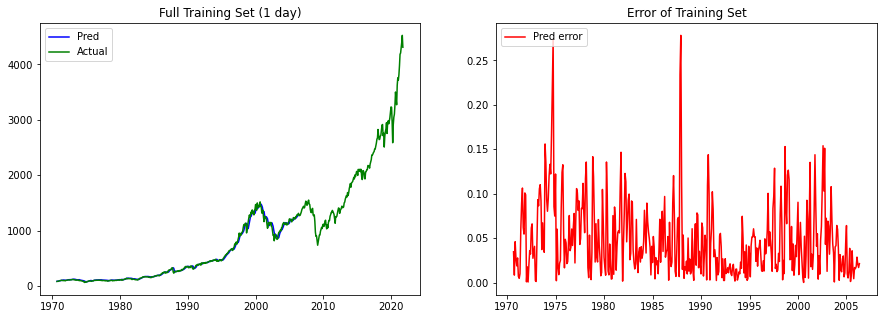

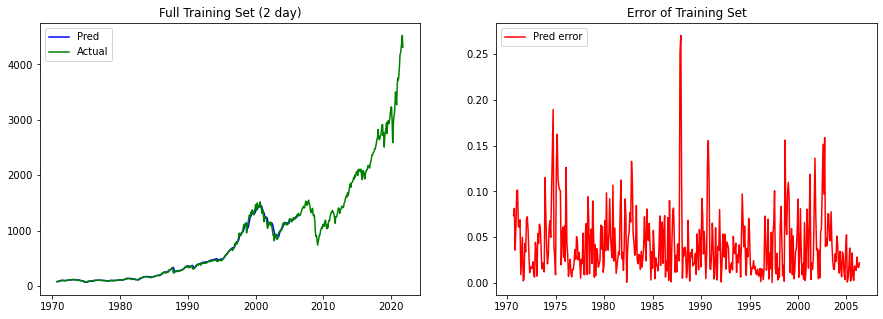

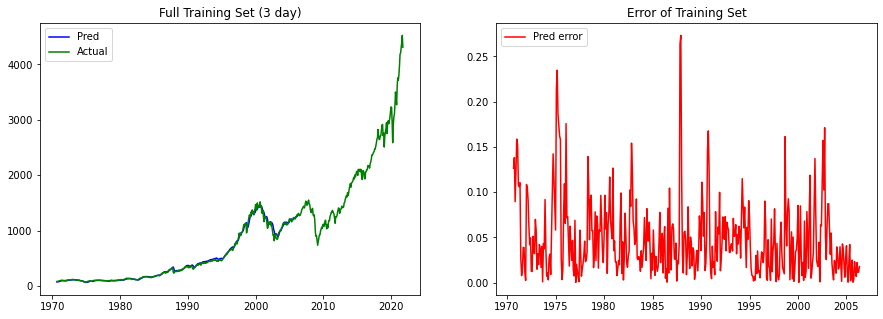

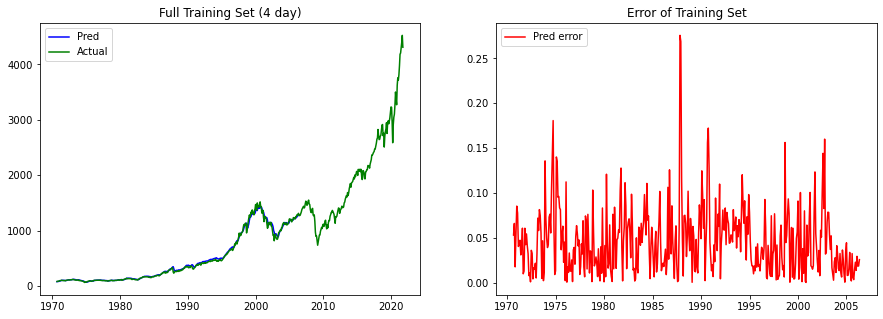

In [10]:
output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_plt = norm.inverse_transform(Y[:, :, 0])
Y_fullTrainingplt = norm.inverse_transform(Y_fullTraining[:, :, 0])

plotNoiselessGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_fullTrainingplt,Y_plt,dateAxis,date_ft,
"Full Training Set (1 day)","Full Training Set (2 day)","Full Training Set (3 day)","Full Training Set (4 day)","Error of Training Set")

# Step 4 

Mean   STD-dev  Skewness  Kurtosis
1 day  0.088312  0.074298  1.582376  2.231156
2 day  0.113840  0.101794  1.501154  1.943349
3 day  0.125559  0.117239  1.491396  1.887437
4 day  0.125875  0.110716  1.306918  1.232988

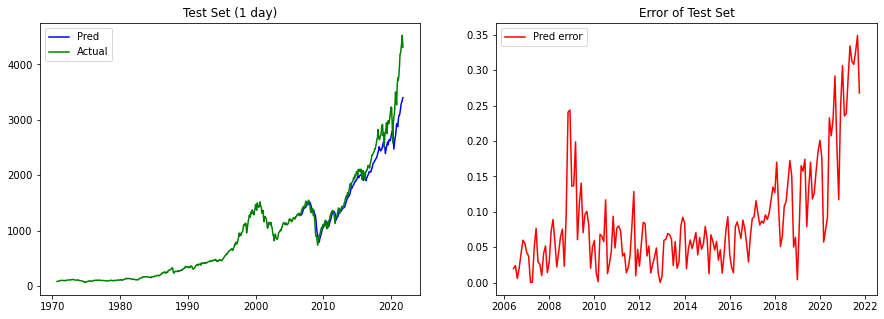

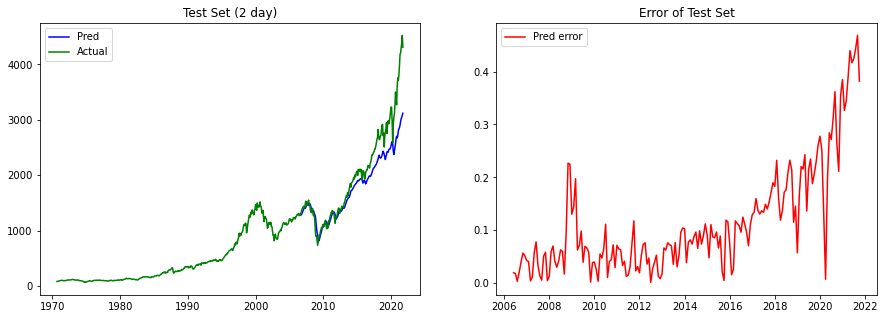

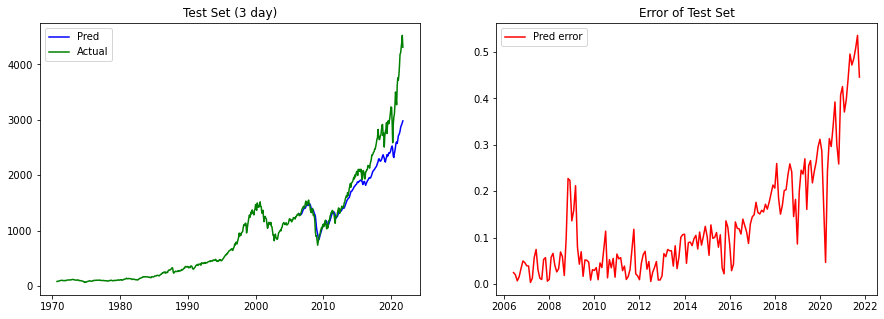

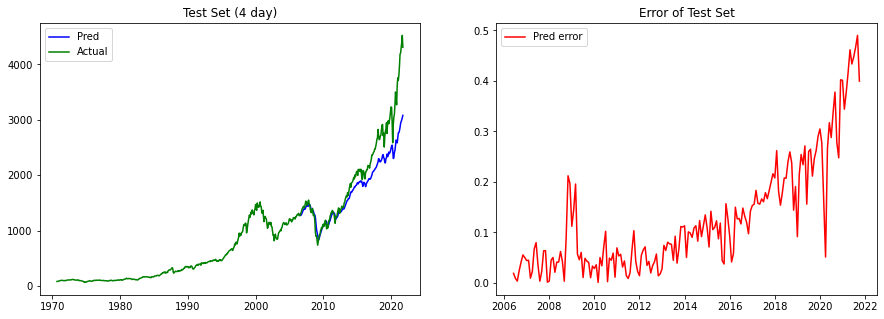

In [11]:
RNN.eval()
xTensor = torch.from_numpy(X_test).float()
output, _ = RNN(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

plotNoiselessGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_testplt,Y_plt,dateAxis,date_t,
"Test Set (1 day)","Test Set (2 day)","Test Set (3 day)","Test Set (4 day)","Error of Test Set")

# Step 5

In [12]:
RNNval = Model(input_size=2, output_size=4, hidden_dim=32, n_layers=2)
optimizerVal = torch.optim.Adam(RNNval.parameters(), lr=0.002)
criterionVal = nn.MSELoss()
RNNval

xTensor = torch.from_numpy(X_training).float()
yTensor = torch.Tensor(Y_training).float()

for epoch in range(200):
    optimizerVal.zero_grad()
    
    output, hidden = RNNval(xTensor)
    loss = criterionVal(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizerVal.step()
    
    if epoch%100 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 200), end=' ')
        print("Loss:", loss.item())

Epoch: 0/200............. Loss: 0.01645461469888687
Epoch: 100/200............. Loss: 1.6569409126532264e-05


Mean   STD-dev  Skewness  Kurtosis
1 day  0.052822  0.044140  1.514737  3.811232
2 day  0.054856  0.045586  1.581045  4.318227
3 day  0.055780  0.045679  1.613687  4.623645
4 day  0.057284  0.045879  1.733529  5.312726

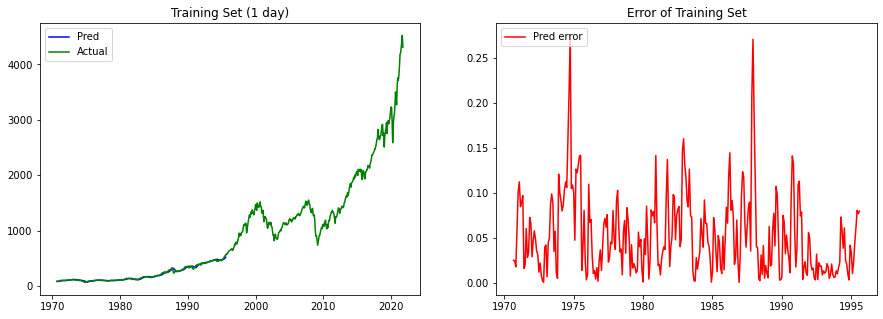

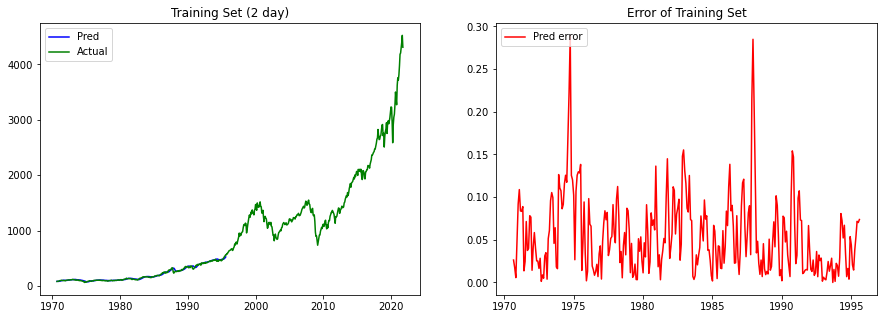

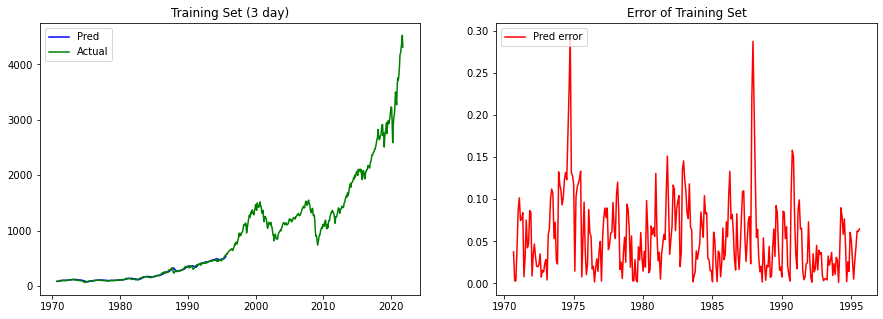

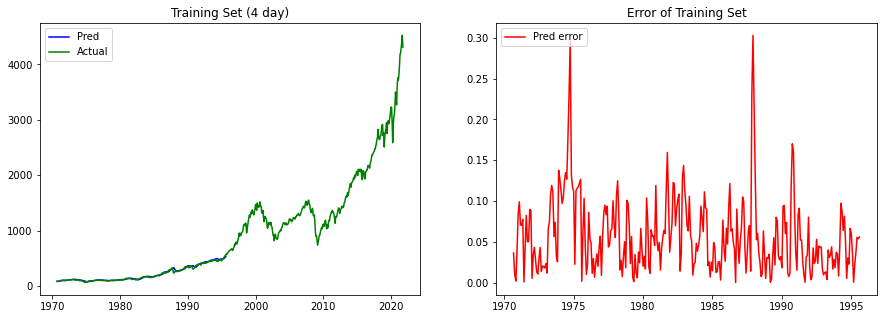

In [13]:
output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_plt = norm.inverse_transform(Y[:, :, 0])
Y_trainingplt = norm.inverse_transform(Y_training[:, :, 0])

plotNoiselessGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_trainingplt,Y_plt,dateAxis,date_tr,
"Training Set (1 day)","Training Set (2 day)","Training Set (3 day)","Training Set (4 day)","Error of Training Set")

Mean   STD-dev  Skewness  Kurtosis
1 day  0.062131  0.039932  0.816549  0.443923
2 day  0.059341  0.041452  0.954281  0.755916
3 day  0.052742  0.041701  1.216108  1.553788
4 day  0.050216  0.042772  1.296010  1.639037

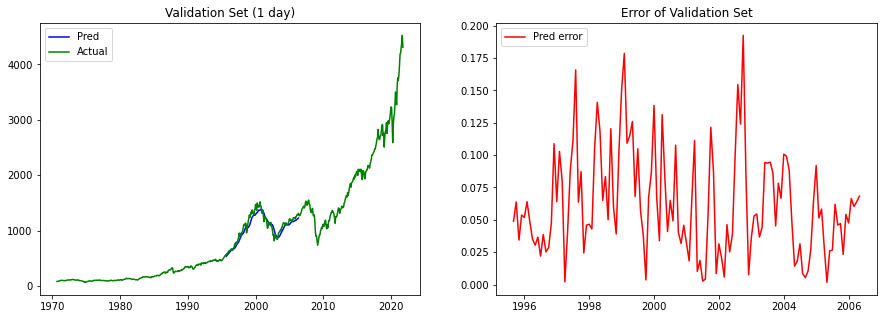

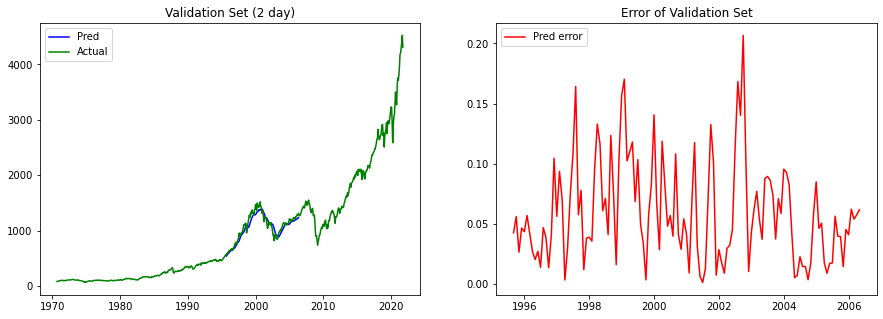

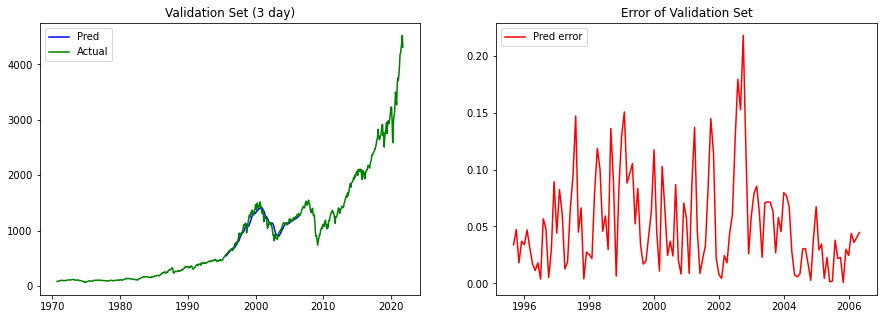

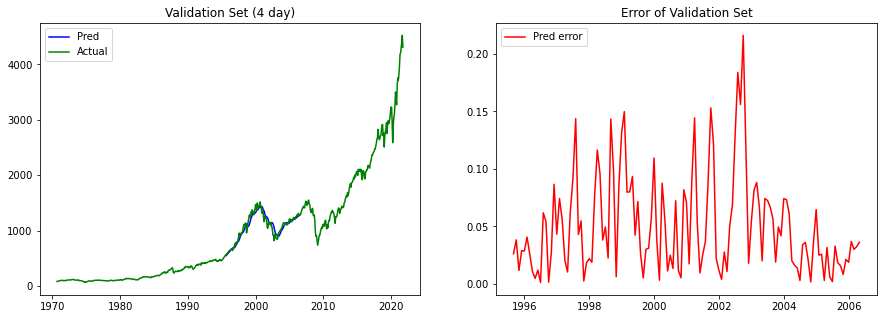

In [14]:
RNNval.eval()
xTensor = torch.from_numpy(X_validation).float()
output, _ = RNNval(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_validationplt = norm.inverse_transform(Y_validation[:, :, 0])

plotNoiselessGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_validationplt,Y_plt,dateAxis,date_v,
"Validation Set (1 day)","Validation Set (2 day)","Validation Set (3 day)","Validation Set (4 day)","Error of Validation Set")

Mean   STD-dev  Skewness  Kurtosis
1 day  0.192306  0.156901  1.445831  1.924493
2 day  0.215578  0.191207  1.550710  2.228224
3 day  0.186517  0.169500  1.551187  2.231906
4 day  0.148640  0.128492  1.441889  1.823090

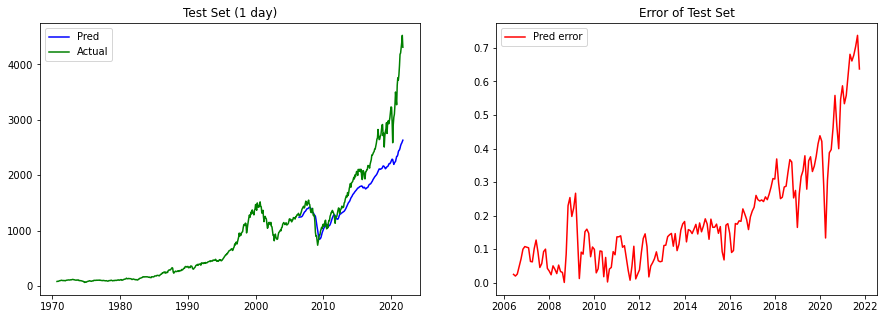

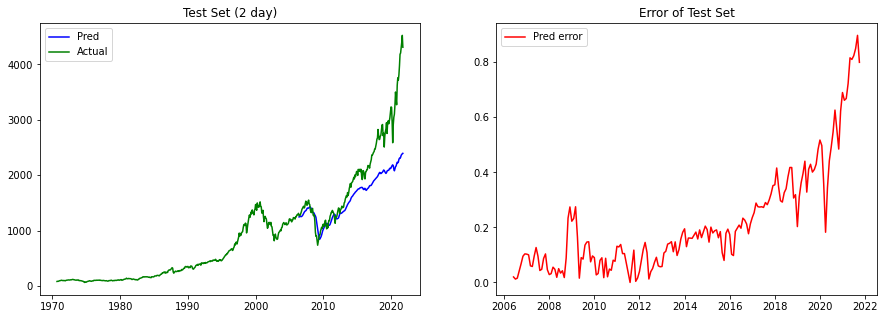

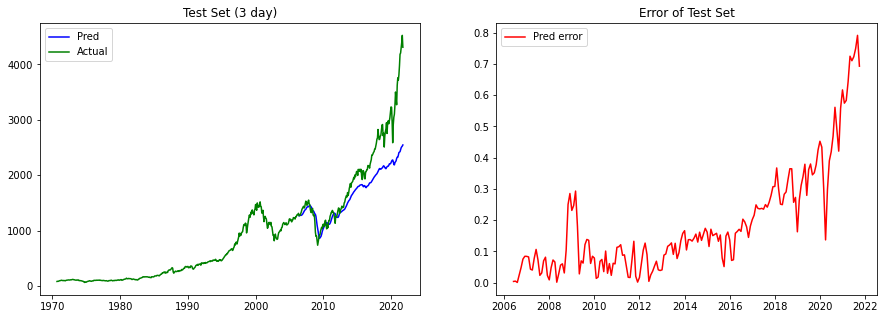

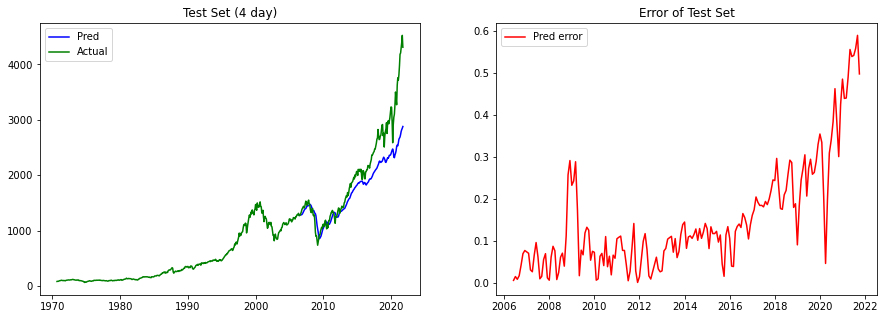

In [15]:
xTensor = torch.from_numpy(X_test).float()
output, _ = RNNval(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

plotNoiselessGraphs(output_plt1,output_plt2,output_plt3,output_plt4,Y_testplt,Y_plt,dateAxis,date_t,
"Test Set (1 day)","Test Set (2 day)","Test Set (3 day)","Test Set (4 day)","Error of Test Set")

# Step 6

In [16]:
def predict(day_index):
    out_temp = np.concatenate( (Y_test[:, :, day_index], Y_test[:, :, day_index], Y_test[:, :, day_index]), axis = 1)
    target = norm.inverse_transform(out_temp)[:, [0]]
    error_res_all = []
    for sigma in stdev:
        noisy_data = NoisyTesting(X_test, sigma)
        inputs = Variable(torch.from_numpy(noisy_data).float())
        output, _ = RNNval(inputs)
        out_temp = np.concatenate((output.detach().numpy()[:, [day_index]], 
                                   output.detach().numpy()[:, [day_index]],  
                                   output.detach().numpy()[:, [day_index]]), axis=1)
        predicted_price = norm.inverse_transform(out_temp)[:, [0]]
        error = prediction_error(target, predicted_price)
        error_res_all.append(error.reshape(-1))
    return error_res_all

In [17]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
def FullGraphing(day):
    plt.figure(1, figsize=(15, 5))
    for i in range(len(stdev)): 
        #print(np.shape(date_test))
        #print(np.shape(error_res_all[i]))
        #print(np.shape(cmaps[i]))
        plt.plot(np.squeeze(date_test), error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next ' +day+ ' day)')
    plt.legend(loc="lower right") 
    ax2=plt.twinx()
    ax2.set_xticks(ax2.get_xticks()[::10])

In [18]:
def IndividualGraphing(day):
    for i in range(len(stdev)): 
        plt.figure(1, figsize=(15, 5))
        plt.plot(np.squeeze(date_test), error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  
        plt.xlabel('Date')
        plt.ylabel('Prediction error')
        plt.title('Prediction error with Different Noise Levels (next '+day+' day)')
        plt.legend(loc="lower right")
        ax2=plt.twinx()
        ax2.set_xticks(ax2.get_xticks()[::20])  
        plt.show()

In [19]:
print("NOISY")
stdev = [0,0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]

def NoisyTesting(dataset, sigma):
    noisy_data = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(6):
        s = np.random.normal(0, sigma, 20)
        index = random.sample(list(range(180)), 20)
        noisy_data[i] = dataset[i]
        noisy_data[index, i, 0] = noisy_data[index, i, 0] + s
    return noisy_data

NOISY


0.000     0.001     0.002     0.003     0.005     0.010  \
01/08/2006  0.023894  0.023891  0.024251  0.023741  0.022475  0.024249   
01/09/2006  0.019145  0.019598  0.019098  0.017723  0.013595  0.015815   
01/10/2006  0.024933  0.024933  0.024933  0.024933  0.024933  0.024933   
01/11/2006  0.045410  0.045789  0.044216  0.043701  0.042172  0.048976   
01/12/2006  0.066188  0.066188  0.066188  0.066188  0.066188  0.066188   
...              ...       ...       ...       ...       ...       ...   
01/08/2021  1.661013  0.358938  0.819079  0.127257  1.664518  0.487973   
01/09/2021  1.646648  0.262532  0.819203  1.537383  0.848874  0.509287   
01/10/2021  1.632266  0.712615  1.607054  1.127692  0.881800  1.490416   
01/11/2021  1.614452  1.614078  1.614452  1.309112  0.910987  0.597997   
01/12/2021  1.645141  0.245002  1.645141  1.593120  0.887209  0.597036   

               0.020     0.030     0.050     0.100  
01/08/2006  0.023268  0.021973  0.034587  0.034002  
01/09/2006  0.008399  0.006909  0.049151  0.041433  
01/10/2006  0.024933  0.024933  0.024933  0.024933  
01/11/2006  0.058103  0.038257  0.003387  0.033800  
01/12/2006  0.066188  0.066188  0.066188  0.066188  
...              ...       ...       ...       ...  
01/08/2021  1.699060  1.664518  0.840375  1.699060  
01/09/2021  1.293776  0.848874  0.806058  1.294130  
01/10/2021  0.765971  0.881800  1.215305  0.765971  
01/11/2021  0.904738  0.910987  1.199829  0.909630  
01/12/2021  0.800373  0.887209  1.231691  0.800373  

[185 rows x 10 columns]

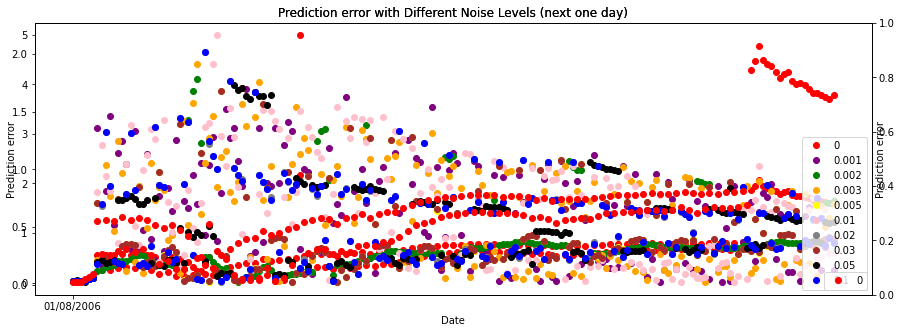

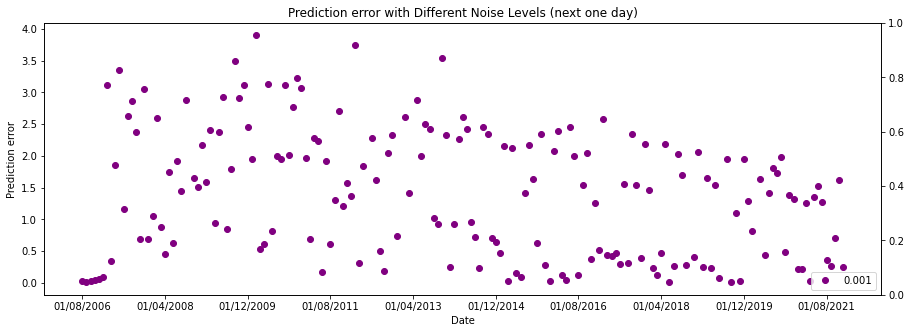

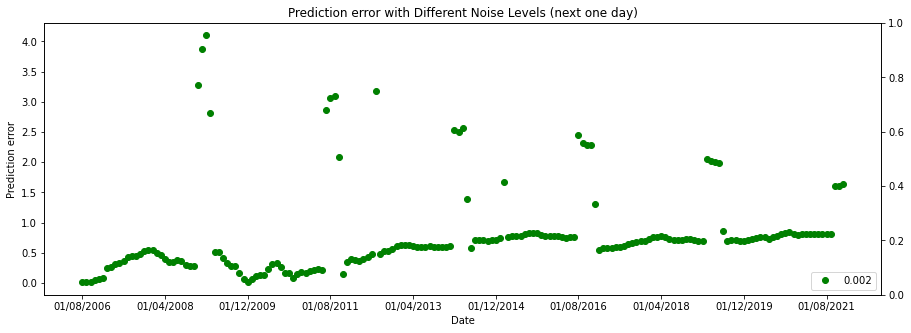

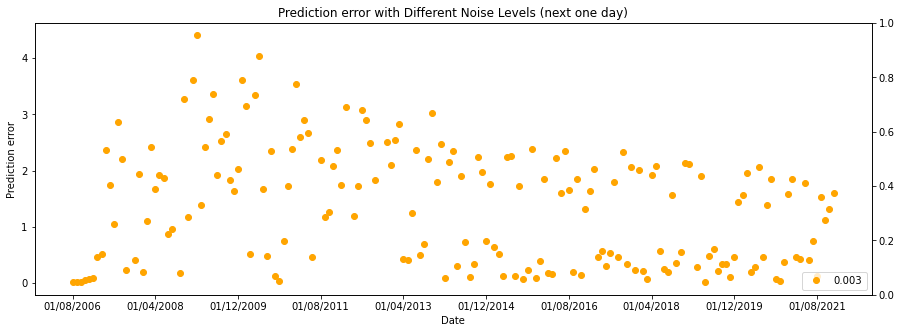

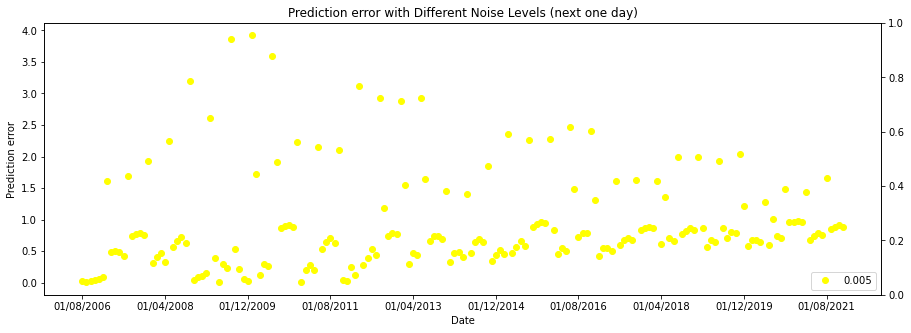

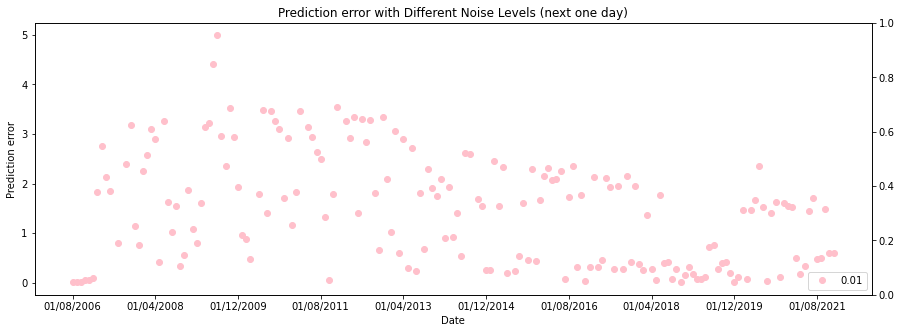

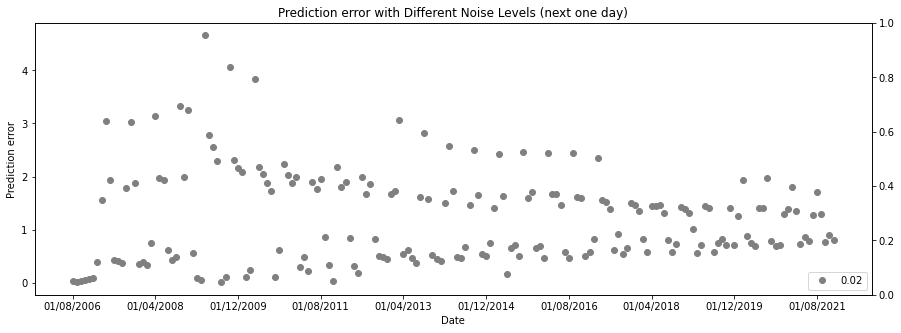

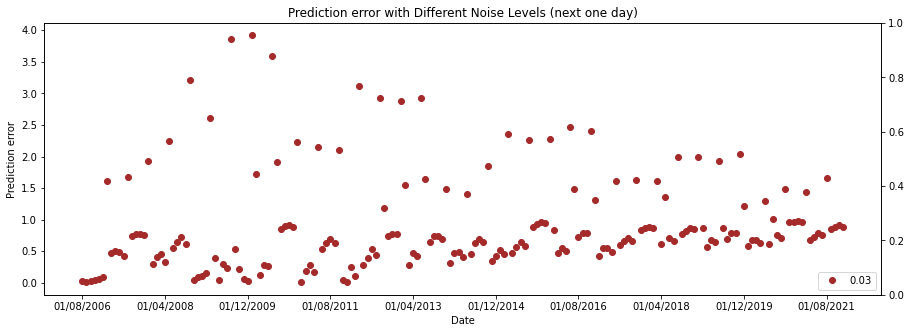

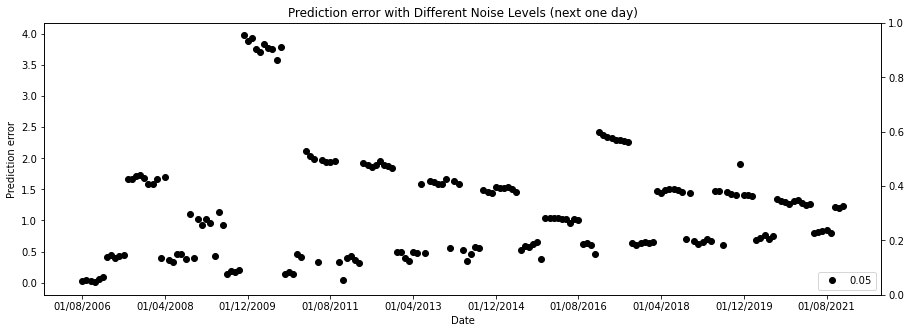

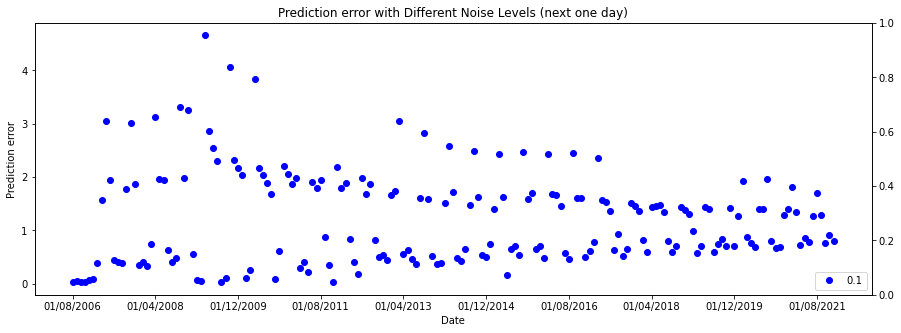

In [20]:
error_res_all=predict(0)

labels = date_test[:,0]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("one")
IndividualGraphing("one")

0.000     0.001     0.002     0.003     0.005     0.010  \
01/08/2006  0.019712  0.019770  0.019313  0.019456  0.020548  0.017588   
01/09/2006  0.017133  0.017426  0.017078  0.016778  0.017421  0.017694   
01/10/2006  0.035948  0.035948  0.035948  0.035948  0.035948  0.035948   
01/11/2006  0.062483  0.062654  0.062902  0.061891  0.062054  0.061559   
01/12/2006  0.091738  0.091738  0.091738  0.091738  0.091738  0.091738   
...              ...       ...       ...       ...       ...       ...   
01/08/2021  0.984633  0.984633  0.984633  0.984633  0.984695  0.984537   
01/09/2021  0.984975  0.984975  0.984975  0.984963  0.953911  0.469983   
01/10/2021  0.985398  0.985398  0.985398  0.985398  0.985398  1.194448   
01/11/2021  0.984669  0.984669  0.984669  0.984732  0.984120  1.237129   
01/12/2021  0.985660  0.985660  0.985660  0.985660  0.985660  1.350108   

               0.020     0.030     0.050     0.100  
01/08/2006  0.019549  0.015464  0.019052  0.022337  
01/09/2006  0.016128  0.024172  0.012437  0.007533  
01/10/2006  0.035948  0.035948  0.035948  0.035948  
01/11/2006  0.062984  0.064224  0.053145  0.059199  
01/12/2006  0.091738  0.091738  0.091738  0.091738  
...              ...       ...       ...       ...  
01/08/2021  0.984518  0.815690  0.985344  1.043812  
01/09/2021  0.950309  0.652495  0.949690  0.923000  
01/10/2021  0.909064  0.242275  0.985037  0.982636  
01/11/2021  0.983879  0.908527  0.950024  0.925757  
01/12/2021  0.985595  1.092497  0.955604  1.221347  

[185 rows x 10 columns]

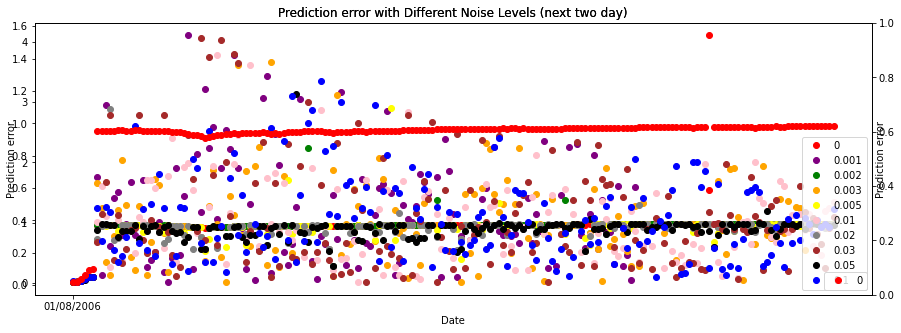

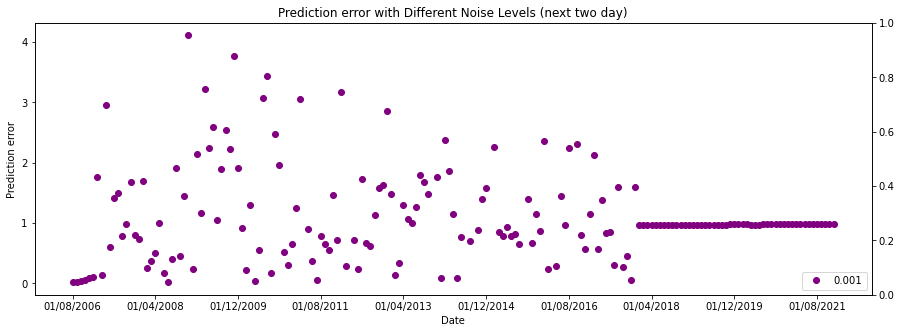

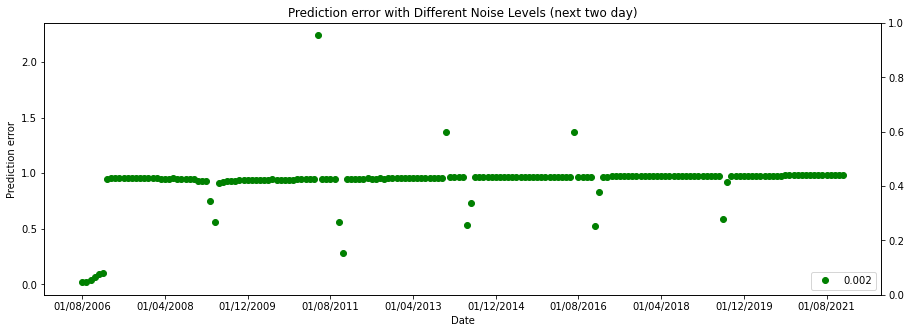

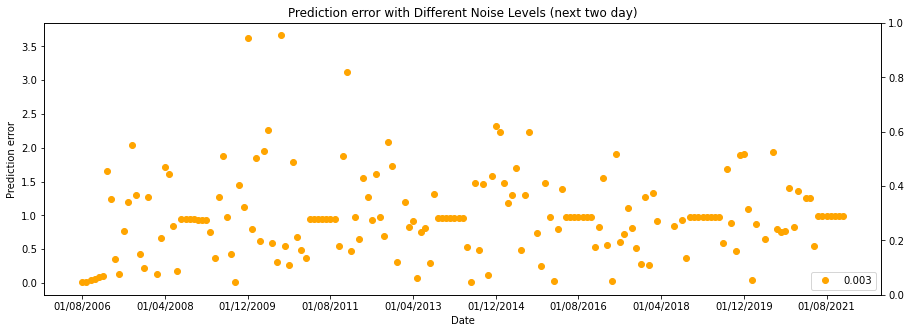

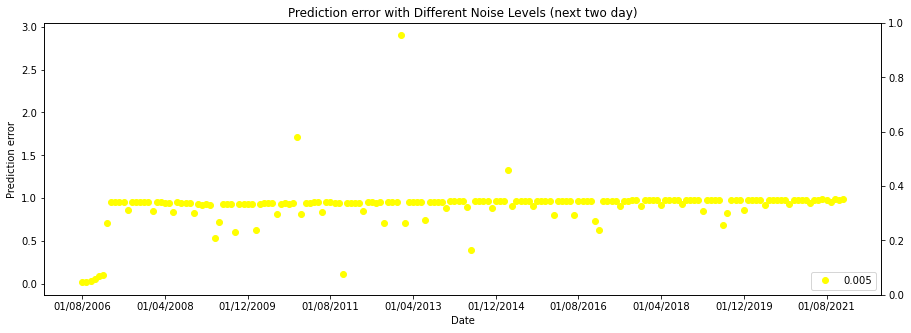

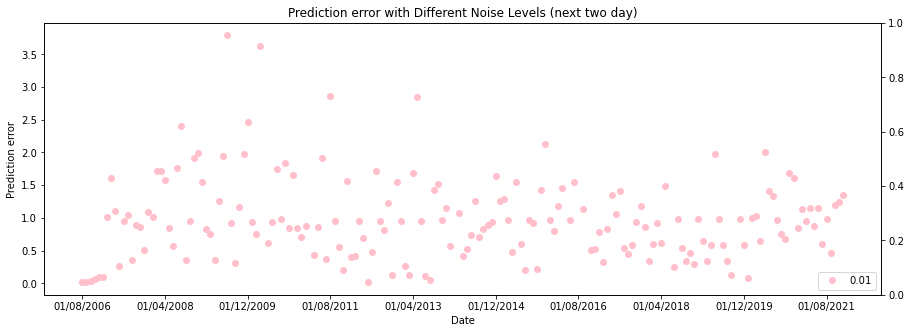

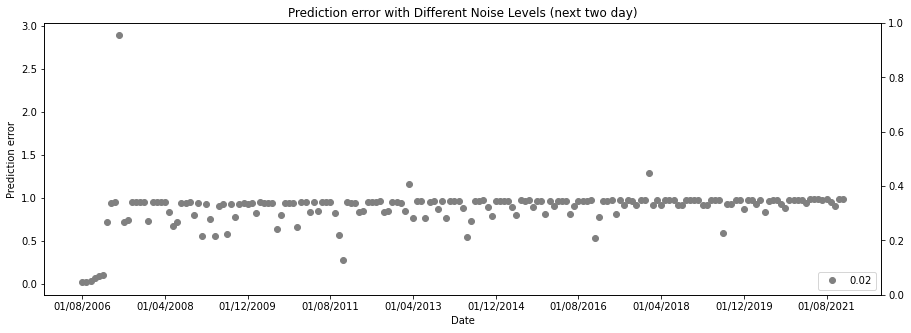

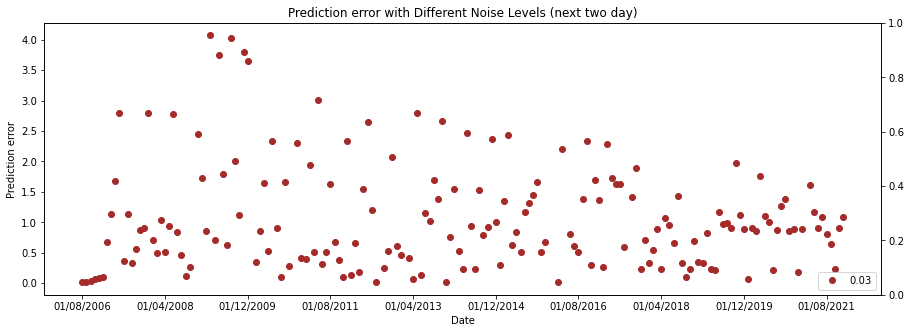

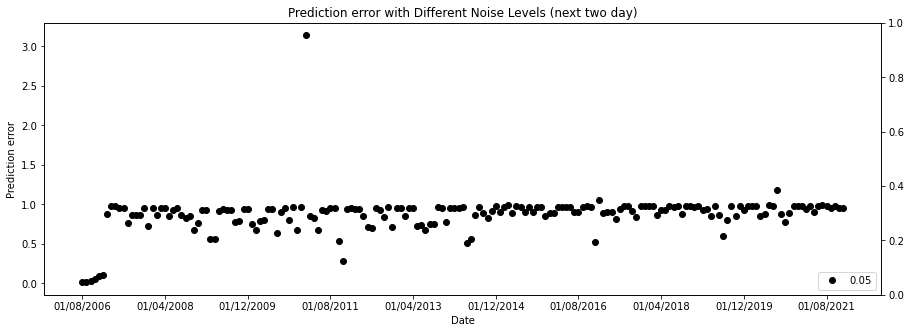

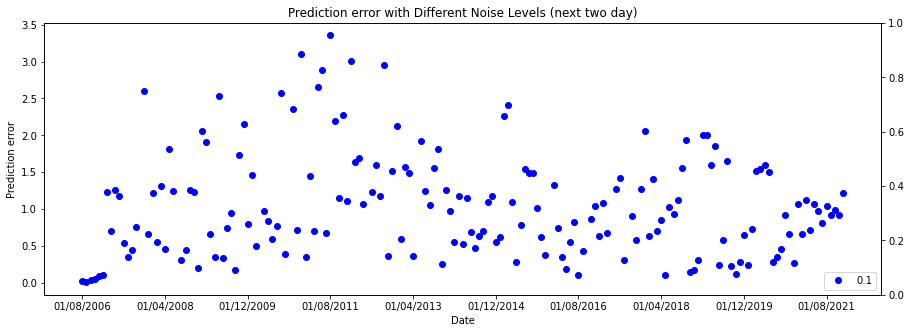

In [21]:
error_res_all=predict(1)

output.detach().numpy()[:,0:1]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("two")
IndividualGraphing("two")

0.000     0.001     0.002     0.003     0.005     0.010  \
01/08/2006  0.008613  0.008694  0.009062  0.007852  0.007636  0.008246   
01/09/2006  0.021425  0.021357  0.021472  0.021972  0.023403  0.022173   
01/10/2006  0.044564  0.044564  0.044564  0.044564  0.044564  0.044564   
01/11/2006  0.075808  0.075952  0.075960  0.075965  0.076726  0.077784   
01/12/2006  0.089577  0.089577  0.089577  0.089577  0.089577  0.089577   
...              ...       ...       ...       ...       ...       ...   
01/08/2021  1.509780  0.984870  1.245469  0.984840  1.245469  0.984870   
01/09/2021  0.985296  0.985296       NaN  0.985296       NaN  0.927260   
01/10/2021  0.984562  0.984562  0.984562  0.984686  0.984562  1.372851   
01/11/2021  1.253278  0.985560  0.985560  0.985560  0.985560       NaN   
01/12/2021       NaN  0.985439  1.255406  0.985439  1.255406  1.164995   

               0.020     0.030     0.050     0.100  
01/08/2006  0.011603  0.004032  0.021861  0.006951  
01/09/2006  0.024876  0.032821  0.023673  0.013316  
01/10/2006  0.044564  0.044564  0.044564  0.044564  
01/11/2006  0.073683  0.069231  0.071850  0.088617  
01/12/2006  0.089577  0.089577  0.089577  0.089577  
...              ...       ...       ...       ...  
01/08/2021  0.915827  0.985850  1.213079  0.949271  
01/09/2021  1.257909  0.937913  1.233648  1.286105  
01/10/2021       NaN       NaN  1.246965  0.946987  
01/11/2021  1.486522  0.975800  1.240320  0.949563  
01/12/2021       NaN  0.904718  1.236396  0.949338  

[185 rows x 10 columns]

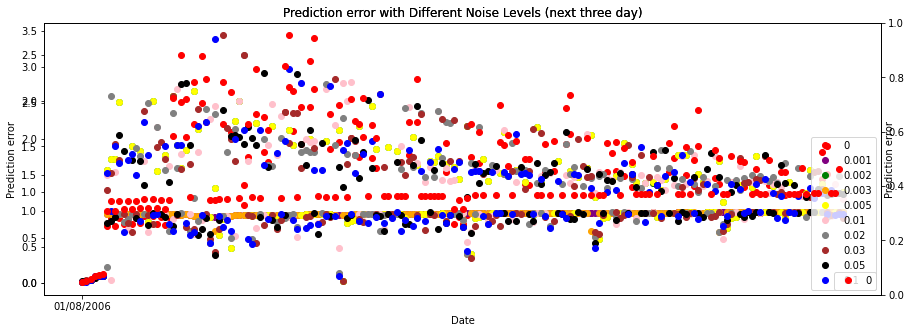

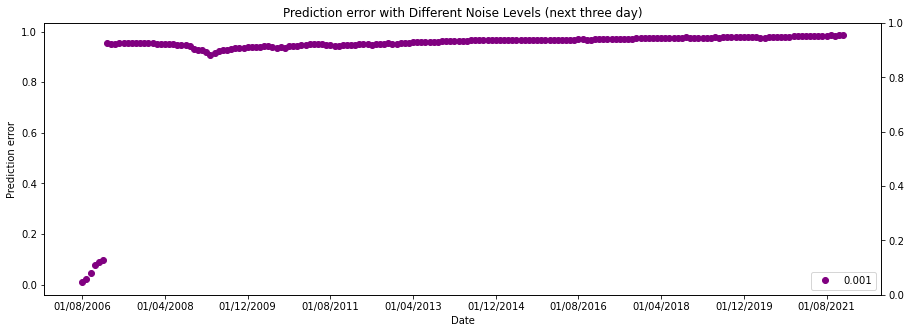

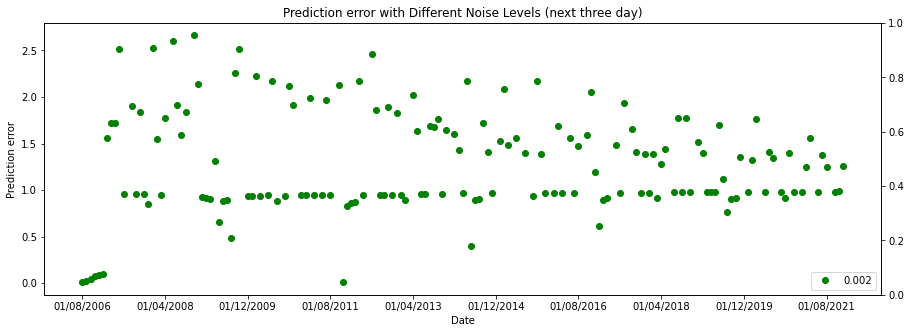

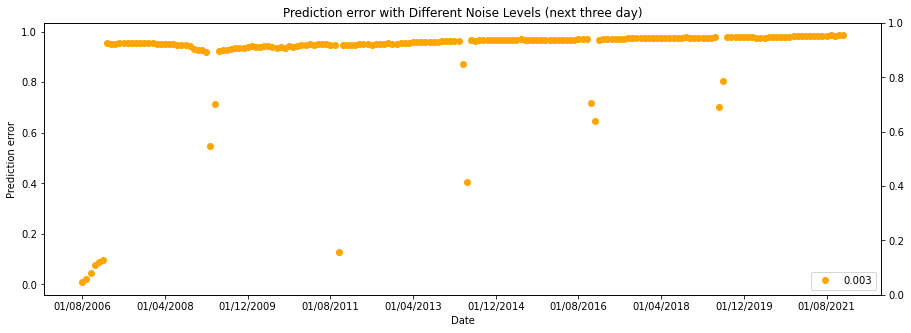

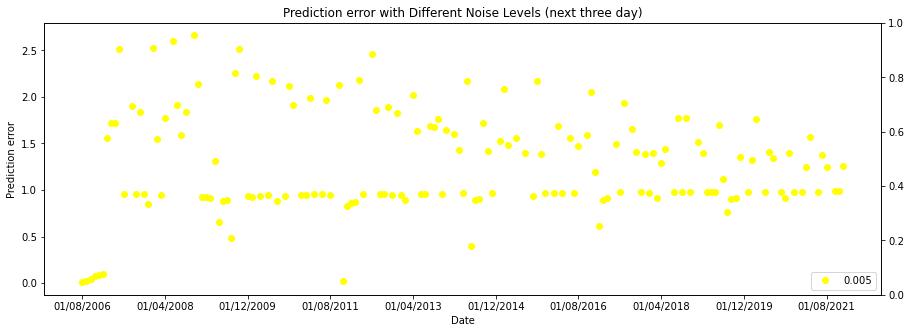

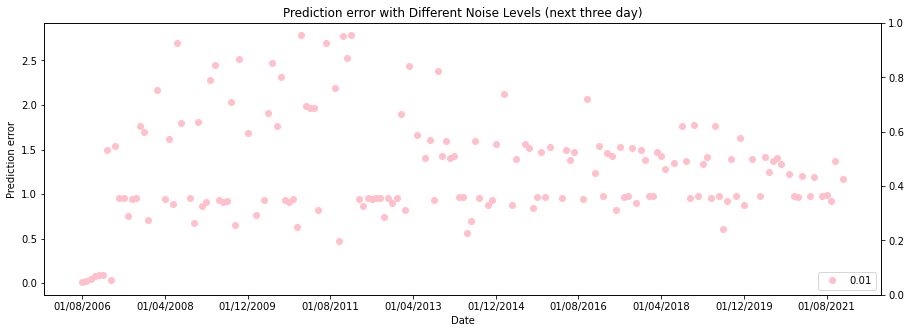

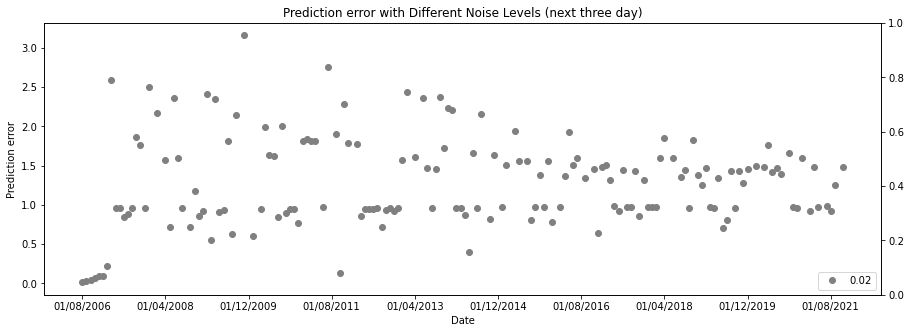

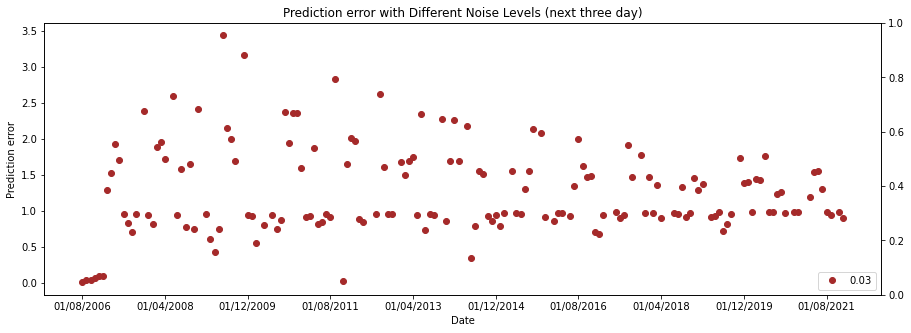

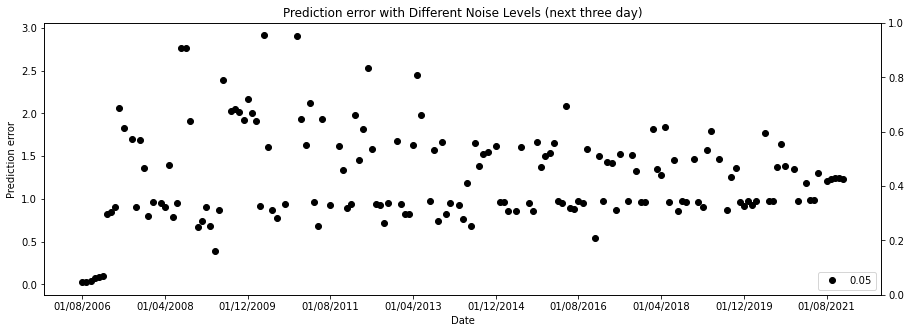

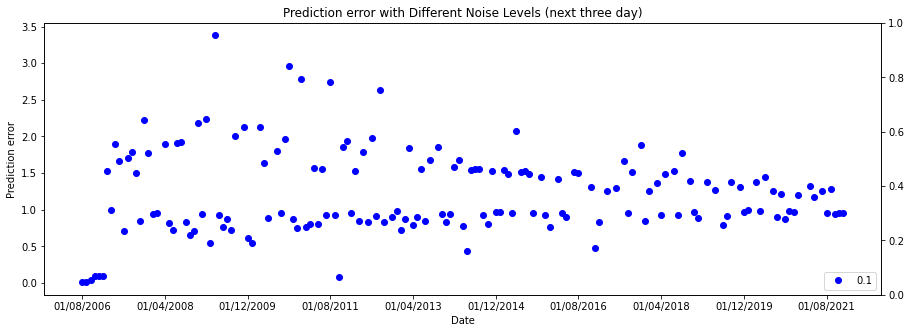

In [22]:
error_res_all=predict(2)

output.detach().numpy()[:,0:2]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("three")
IndividualGraphing("three")

0.000     0.001     0.002     0.003     0.005     0.010  \
01/08/2006  0.020631  0.020398  0.020126  0.020350  0.021829  0.021853   
01/09/2006  0.035141  0.035368  0.035891  0.034145  0.036442  0.034143   
01/10/2006  0.066154  0.066154  0.066154  0.066154  0.066154  0.066154   
01/11/2006  0.084117  0.083973  0.085777  0.085011  0.083626  0.086611   
01/12/2006  0.095451  0.095451  0.095451  0.095451  0.095451  0.095451   
...              ...       ...       ...       ...       ...       ...   
01/08/2021  0.942162  0.989921  0.902830  0.378053  0.984649  1.372440   
01/09/2021  1.862512  0.962205  1.225709  0.167441  0.740452  0.025594   
01/10/2021  0.958025  0.984096  0.991231  0.936451  1.692893  0.096824   
01/11/2021  0.957062  0.375251  0.974173  0.811340  0.940111  0.188233   
01/12/2021  0.958936  1.892892       NaN  0.822886  0.957771  0.855473   

               0.020     0.030     0.050     0.100  
01/08/2006  0.022733  0.020644  0.037779  0.041462  
01/09/2006  0.032636  0.043499  0.020834  0.074024  
01/10/2006  0.066154  0.066154  0.066154  0.066154  
01/11/2006  0.106751  0.100761  0.074711  0.082606  
01/12/2006  0.095451  0.095451  0.095451  0.095451  
...              ...       ...       ...       ...  
01/08/2021  0.939191  0.608692  1.075764  0.315610  
01/09/2021  1.628126  0.342653  0.932973  0.152929  
01/10/2021  1.132935  1.234328  0.868721  0.736973  
01/11/2021  0.919530  0.272282  1.214533  1.345037  
01/12/2021  1.664691  1.645587  1.386095       NaN  

[185 rows x 10 columns]

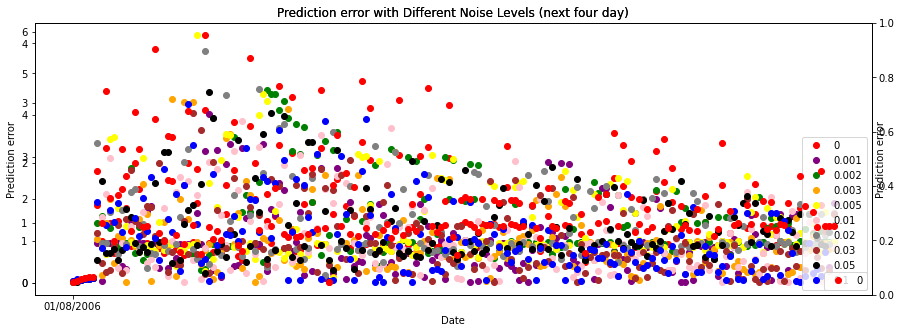

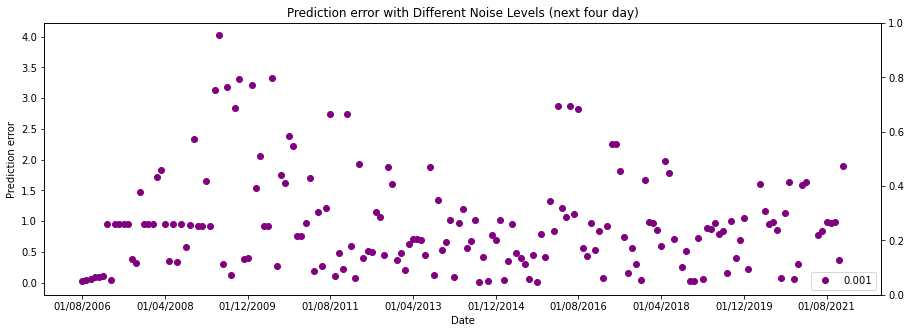

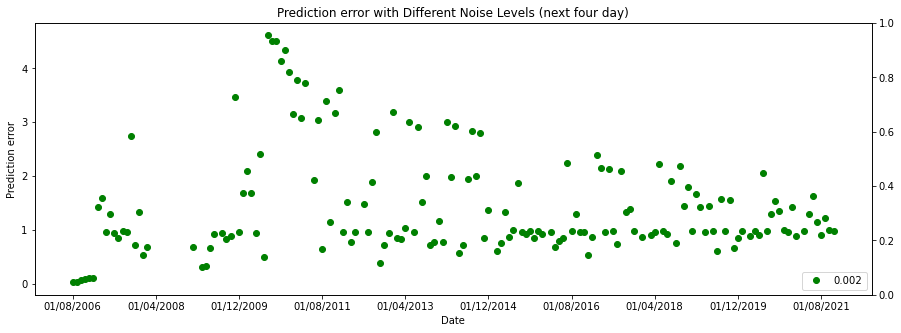

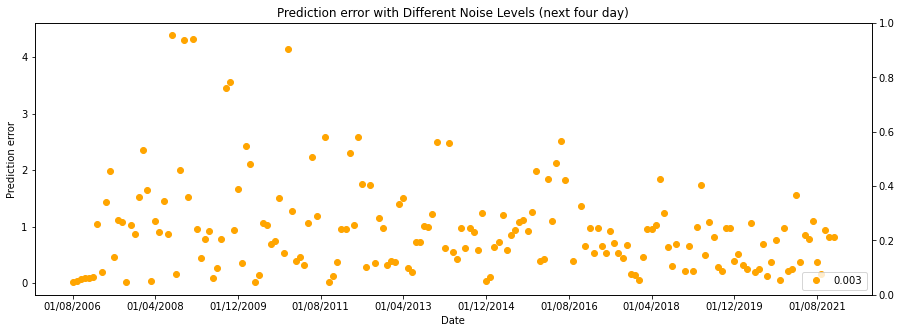

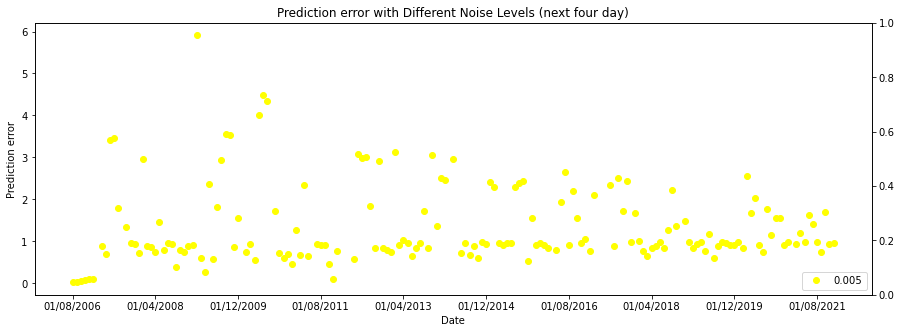

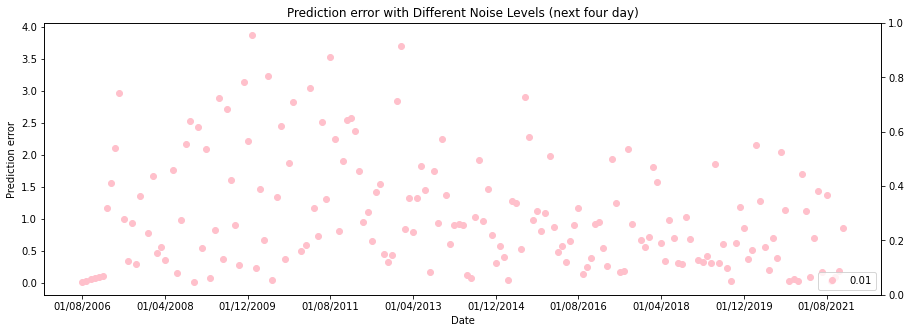

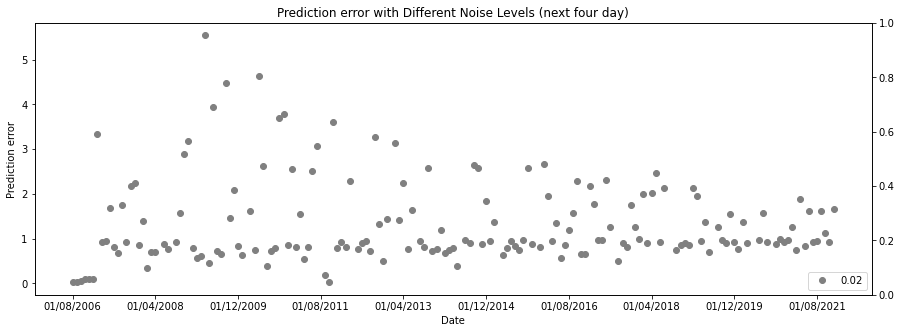

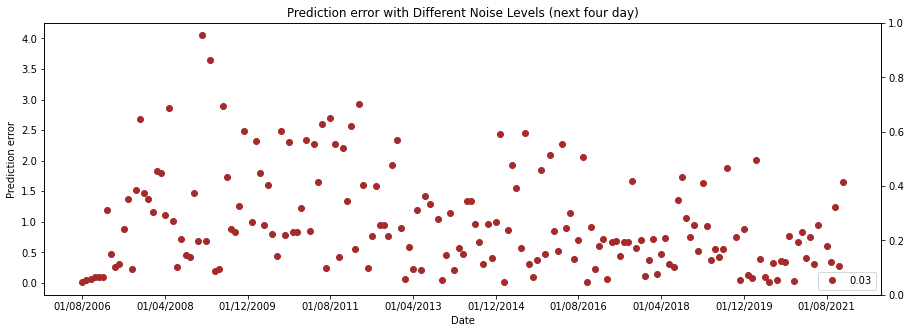

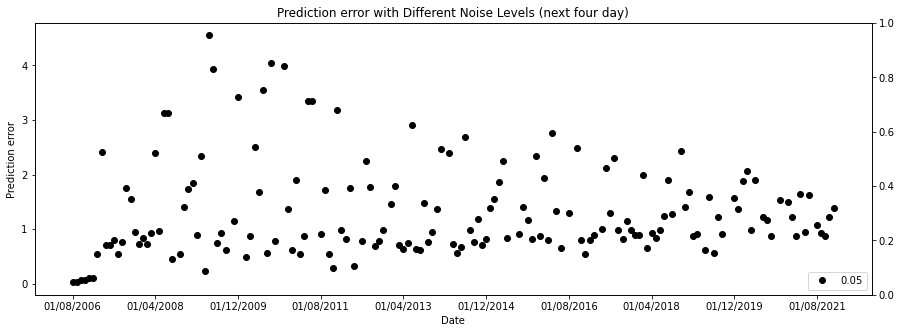

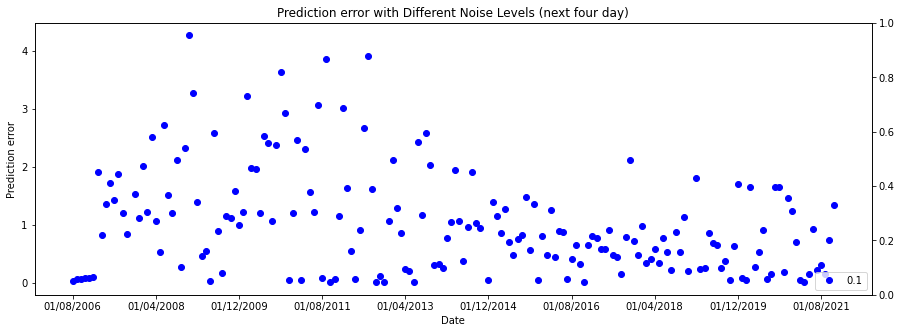

In [23]:
error_res_all=predict(3)

output.detach().numpy()[:,0:3]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("four")
IndividualGraphing("four")